In [1]:
import os

!pip install matplotlib -q

import pandas as pd

## Data loading

In [2]:
!ls $HOME/ds-bowl-from-scratch/raw-data

sample_submission.csv test.csv              train_labels.csv
specs.csv             train.csv


In [3]:
home = os.environ['HOME']
home

'/Users/adam'

In [4]:
# os.path OR pathlib
home = os.path.join(os.environ['HOME'], 'ds-bowl-from-scratch', 'raw-data')
print(home)

/Users/adam/ds-bowl-from-scratch/raw-data


In [5]:
os.listdir(home)

['train_labels.csv',
 'test.csv',
 'specs.csv',
 'train.csv',
 'sample_submission.csv']

In [6]:
raw_data = {}

for fi in os.listdir(home):
    if 'csv' in fi:
        print(fi)
        raw_data[fi] = pd.read_csv(os.path.join(home, fi))

train_labels.csv
test.csv
specs.csv
train.csv
sample_submission.csv


## Basic data inspection

Look at all csvs

In [7]:
for name, df in raw_data.items():
    print(name, df.shape)
    print(df.columns)
    print(' ')

train_labels.csv (17690, 7)
Index(['game_session', 'installation_id', 'title', 'num_correct', 'num_incorrect', 'accuracy', 'accuracy_group'], dtype='object')
 
test.csv (1156414, 11)
Index(['event_id', 'game_session', 'timestamp', 'event_data', 'installation_id', 'event_count', 'event_code', 'game_time', 'title', 'type', 'world'], dtype='object')
 
specs.csv (386, 3)
Index(['event_id', 'info', 'args'], dtype='object')
 
train.csv (11341042, 11)
Index(['event_id', 'game_session', 'timestamp', 'event_data', 'installation_id', 'event_count', 'event_code', 'game_time', 'title', 'type', 'world'], dtype='object')
 
sample_submission.csv (1000, 2)
Index(['installation_id', 'accuracy_group'], dtype='object')
 


## Inspection of the target

Four classes

In [8]:
labels = raw_data['train_labels.csv']
set(labels.loc[:, 'accuracy_group'])

{0, 1, 2, 3}

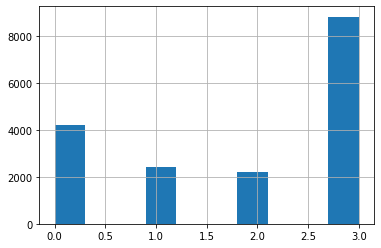

In [9]:
labels.loc[:, 'accuracy_group'].hist()

Number of installs

In [10]:
def inspect_df(data, csv):
    """
    show unique values in all cols of a df 
    
    data (dict)
    csv (str)
    """
    df = data[csv]
    for col in df.columns:
        print(col)
        uniq = len(set(df.loc[:, col]))
        print('num. uniques {}'.format(uniq))
        print(uniq / df.shape[0])
        print(' ')
        
inspect_df(raw_data, 'train_labels.csv')

game_session
num. uniques 17690
1.0
 
installation_id
num. uniques 3614
0.20429621254946298
 
title
num. uniques 5
0.0002826455624646693
 
num_correct
num. uniques 2
0.00011305822498586772
 
num_incorrect
num. uniques 46
0.0026003391746749578
 
accuracy
num. uniques 30
0.0016958733747880158
 
accuracy_group
num. uniques 4
0.00022611644997173544
 


In [11]:
raw_data.keys()

dict_keys(['train_labels.csv', 'test.csv', 'specs.csv', 'train.csv', 'sample_submission.csv'])

## Event data

In [12]:
raw_data['train_labels.csv'].iloc[0, :]

game_session                   6bdf9623adc94d89
installation_id                        0006a69f
title              Mushroom Sorter (Assessment)
num_correct                                   1
num_incorrect                                 0
accuracy                                      1
accuracy_group                                3
Name: 0, dtype: object

In [47]:
def extract_game_session(data, idx):
    df = data['train_labels.csv']
    row = df.iloc[idx, :]
    return row.to_dict()

gs = extract_game_session(raw_data, 1000)
gs

{'game_session': '0bca967cb0dcc005',
 'installation_id': '0cc2a247',
 'title': 'Cart Balancer (Assessment)',
 'num_correct': 1,
 'num_incorrect': 0,
 'accuracy': 1.0,
 'accuracy_group': 3}

In [48]:
import json

def get_event_data(data, game_session_dict):
    df = data['train.csv']
    sub = df[df.loc[:, 'game_session'] == game_session_dict['game_session']]
    if 'Bird Measurer' in game_session_dict['title']:
        code = 4110
    else:
        code = 4100
        
    out = list(sub[sub.loc[:, 'event_code'] == code].loc[:, 'event_data'])
    
    return [json.loads(j) for j in out]

event_data = get_event_data(raw_data, gs)

event_data

[{'correct': True,
  'left': [{'id': 'gem05', 'weight': 4},
   {'id': 'gem01', 'weight': 1},
   {'id': 'gem03', 'weight': 3},
   {'id': 'gem07', 'weight': 6}],
  'right': [{'id': 'gem06', 'weight': 4},
   {'id': 'gem02', 'weight': 1},
   {'id': 'gem04', 'weight': 3},
   {'id': 'gem08', 'weight': 6}],
  'event_count': 23,
  'game_time': 28667,
  'event_code': 4100}]

3: the assessment was solved on the first attempt

2: the assessment was solved on the second attempt

1: the assessment was solved after 3 or more attempts

0: the assessment was never solved

In [49]:
def get_accuracy_label(corr, incorr):
    corr = sum(corr)
    incorr = sum(incorr)
    
    if corr == 1 and incorr == 0:
        return 3
    elif corr == 1 and incorr == 1:
        return 2
    elif corr == 1 and incorr >= 2:
        return 1
    else:
        return 0
    
def test_get_acc():
    corr, incorr = [1], [0]
    expected = 3
    assert get_accuracy_label(corr, incorr) == expected

    corr, incorr = [0], [10]
    expected = 0
    assert get_accuracy_label(corr, incorr) == expected
    
test_get_acc()

def extract_event_data(events):
    corr, incorr = [], []
    for event in events:
        if event['correct']:
            corr.append(1)
        else:
            incorr.append(1)
    return corr, incorr

def check_labels(game_session_dict, event_data):
    corr, incorr = extract_event_data(event_data)
    assert sum(corr) == game_session_dict['num_correct']
    assert sum(incorr) == game_session_dict['num_incorrect']
    label = get_accuracy_label(corr, incorr)
    assert label == game_session_dict['accuracy_group']
    
    return label
    
check_labels(gs, event_data)

3

In [50]:
data = []
for i in range(5):
    gs = extract_game_session(raw_data, i)
    out = get_event_data(raw_data, gs)
    label = check_labels(gs, out)
    
    data.append({
        'game_session': gs['game_session'],
        'label': label
    })

In [51]:
data = []
for row in range(5):
    #gs = extract_game_session(raw_data, i)
    tr = raw_data['train.csv']
    train_row = tr.iloc[row, :]
    gs_id = {
        'game_session': train_row.loc['game_session'],
        'title': train_row.loc['title']
    }
    
    event_data = get_event_data(raw_data, gs_id)
    corr, incorr = extract_event_data(event_data)
    label = get_accuracy_label(corr, incorr)
    #label = check_labels(gs, out)
    
    data.append({
        'game_session': gs['game_session'],
        'label': label
    })
    

In [ ]:
import json

json.loads(raw_data['train.csv'].loc[:, 'event_data'].iloc[1000])

In [ ]:
raw_data['sample_submission.csv'].head()

In [ ]:
len(set(raw_data['train_labels.csv'].loc[:, 'installation_id']))

In [ ]:
raw_data['train.csv'].shape

In [ ]:
len(set(raw_data['train.csv'].loc[:, 'game_session']))

In [ ]:
len(set(raw_data['train.csv'].loc[:, 'installation_id']))

In [ ]:
df = raw_data['train_labels.csv']

mask = df['accuracy_group'] == 3
mask = df.loc[:, 'accuracy_group'] == 3

sub = df.loc[mask, :]

sub.head()

In [ ]:
set(sub.loc[:, 'num_correct'])

In [ ]:
set(df.loc[:, 'num_correct'])

In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
# hardness of games

In [ ]:
!pip install seaborn -q
import seaborn as sns

sns.pairplot(data['train_labels.csv'])

In [ ]:
mask = df['num_correct'] == 1

mask

In [ ]:
mask2 = df['num_incorrect'] > 0

df.loc[mask & mask2, :].loc[:, 'num_incorrect'].hist()

In [ ]:
max(df.loc[mask & mask2, :].loc[:, 'num_incorrect'])